# Convolutional model implementtion 
## LeNet 5 
### Using Con2d as a convolutional layer and Linear as a linear layer from torch

In [11]:
import torch
import torch.nn as nn #parent
import torch.nn.functional as F #activation func, max pooling funcs
from torch.utils.data import ConcatDataset
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import tensorflow as tf

import math
import numpy as np

import sys
sys.path.append('/home/sandrech/code/ml/square_attack_v2')
from attack import square_attack_l2, square_attack_linf

import utils
from utils import dense_to_onehot

## Creating model

In [12]:
class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #equivalent to nn.Maxpool2d(2)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x= self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features = num_features * s
        return num_features


## Downloading datasets from torchvision and applying transforms to it

In [13]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True,
                                        transform=transform)
x = torch.stack([sample[0] for sample in ConcatDataset([trainset])])
mean = torch.mean(x, dim=(0,2,3))
std = torch.std(x, dim=(0,2,3)) #standart deviation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)])

Files already downloaded and verified


## Organizing data into batches

In [14]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=False, num_workers=2)

## Adding optimizer and loss function

In [15]:
net = LeNet_5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training model

In [21]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

#st = net.state_dict()
#torch.save(st, "conv_model.pth")

[1,  2000] loss: 1.371
[1,  4000] loss: 1.366
[1,  6000] loss: 1.328
[1,  8000] loss: 1.313
[1, 10000] loss: 1.335
[1, 12000] loss: 1.301
[2,  2000] loss: 1.283
[2,  4000] loss: 1.281
[2,  6000] loss: 1.246
[2,  8000] loss: 1.236
[2, 10000] loss: 1.256
[2, 12000] loss: 1.231
[3,  2000] loss: 1.213
[3,  4000] loss: 1.213
[3,  6000] loss: 1.189
[3,  8000] loss: 1.178
[3, 10000] loss: 1.193
[3, 12000] loss: 1.167
[4,  2000] loss: 1.155
[4,  4000] loss: 1.147
[4,  6000] loss: 1.135
[4,  8000] loss: 1.129
[4, 10000] loss: 1.147
[4, 12000] loss: 1.124
[5,  2000] loss: 1.111
[5,  4000] loss: 1.105
[5,  6000] loss: 1.078
[5,  8000] loss: 1.071
[5, 10000] loss: 1.098
[5, 12000] loss: 1.075
Finished Training


## Testing model

In [17]:
correct = 0
total = 0
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 31 %


## Square attack

In [18]:
import square_attack_v2.models
import square_attack_v2.data
from square_attack_v2.data import load_cifar10
sys.path.append("/home/sandrech/code/ml/madry_cifar10/cifar10_data/cifar10_data")
sys.path.append("/home/sandrech/code/ml/square_attack_v2")
dataset = 'cifar10'
model_name = 'pt_post_avg_cifar10'
gpu_memory = 0.99
batch_size = square_attack_v2.data.bs_dict[dataset]


model =  square_attack_v2.models.ModelPT(model_name, batch_size, gpu_memory)

loss = 'margin_loss' #not targeted attack
eps = 5


x_test, y_test = load_cifar10(1000)


n_ex = 10
n_iter = 100
p = 0.05
metrics_path = 'fixed_metrics_file.metrics'
loss = 'cross_entropy'
#x_test, y_test = data
x_test, y_test = x_test[:n_ex], y_test[:n_ex]
x_test /= 255.0
#eps /= 255.0
if (x_test.shape[0] == 0):
    print("emty")
    #continue
y_target_onehot = utils.dense_to_onehot(y_test, n_cls=10) 

logits_clean = model.predict(x_test)
corr_classified = logits_clean.argmax(1) == y_test

n_queries, x_adv = square_attack_l2(model, x_test, y_target_onehot, corr_classified, eps, n_iter,
                                    p, metrics_path, False, loss)   


Initial square side=6 for bumps
1: acc=50.00% acc_corr=55.56% avg#q_ae=1.2 med#q_ae=1.0 s=7->7, n_ex=9, 3s, loss=0.074, max_pert=5.0, impr=1
2: acc=50.00% acc_corr=55.56% avg#q_ae=1.2 med#q_ae=1.0 s=7->5, n_ex=9, 6s, loss=-0.039, max_pert=5.0, impr=2
3: acc=50.00% acc_corr=55.56% avg#q_ae=1.2 med#q_ae=1.0 s=7->5, n_ex=9, 9s, loss=-0.048, max_pert=5.0, impr=1
4: acc=30.00% acc_corr=33.33% avg#q_ae=2.5 med#q_ae=1.5 s=7->3, n_ex=9, 12s, loss=-0.183, max_pert=5.0, impr=3
5: acc=30.00% acc_corr=33.33% avg#q_ae=2.5 med#q_ae=1.5 s=7->3, n_ex=9, 14s, loss=-0.214, max_pert=5.0, impr=2
6: acc=20.00% acc_corr=22.22% avg#q_ae=3.1 med#q_ae=2.0 s=7->3, n_ex=9, 15s, loss=-0.300, max_pert=5.0, impr=1
7: acc=20.00% acc_corr=22.22% avg#q_ae=3.1 med#q_ae=2.0 s=7->3, n_ex=9, 16s, loss=-0.303, max_pert=5.0, impr=1
8: acc=20.00% acc_corr=22.22% avg#q_ae=3.1 med#q_ae=2.0 s=7->3, n_ex=9, 18s, loss=-0.313, max_pert=5.0, impr=2
9: acc=20.00% acc_corr=22.22% avg#q_ae=3.1 med#q_ae=2.0 s=7->3, n_ex=9, 19s, loss=-0

## AQR

In [19]:
cnt_queries = 0
sm_quaries = 0
for i in range (len(n_queries)):
    if n_queries[i]!=0:
        cnt_queries += 1
        sm_quaries += n_queries[i]
print("ASQ ", sm_quaries//cnt_queries)

ASQ  6.0


## Visualisation

original


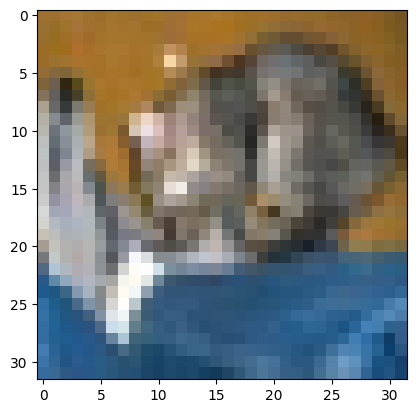

adversal


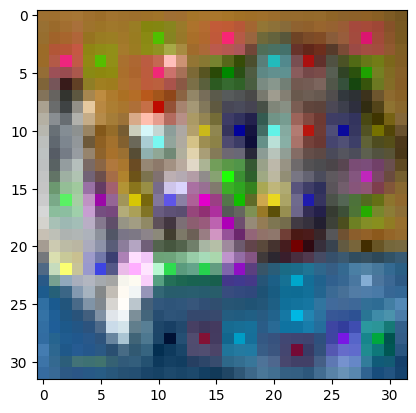

noise


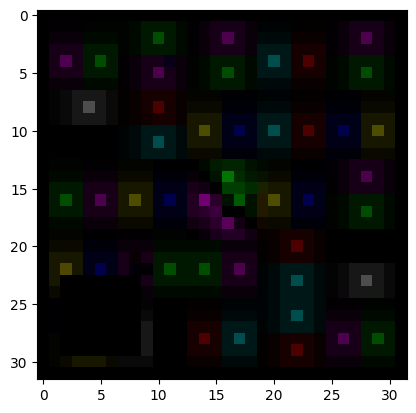

In [20]:
import matplotlib.pyplot as plt
import numpy as np

num_images = 1

original_images = np.squeeze(x_test[:num_images])
original_images = np.transpose(original_images, (1,2,0))

adversarial_images = np.squeeze(x_adv[:num_images])
adversarial_images = np.transpose(adversarial_images, (1, 2, 0))

noise_images = np.clip(adversarial_images - original_images, 0, 1)
print('original')
plt.imshow(original_images)
plt.show()
print('adversal')
plt.imshow(adversarial_images)
plt.show()
print('noise')
plt.imshow(noise_images)
plt.show()
